In [1]:
#Import Relevant libraries
#file extraction
import os
from striprtf.striprtf import rtf_to_text
from os import path

#data manipulation and viz
import pandas as pd
import numpy as np
import datetime as dt
from plotnine import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from mizani.formatters import percent_format

#text analysis
from sklearn.feature_extraction import text
import nltk
from nltk.corpus import wordnet
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer



In [2]:
path_of_the_directory= r'../data'
print("Files and directories in a specified path:")

text = []

for filename in os.listdir(path_of_the_directory):
    try:
        f = os.path.join(path_of_the_directory,filename)
        if os.path.isfile(f):
          print(f)
          open_rtf_file=open(f,'r', encoding='utf-8')
          file_content_read=open_rtf_file.read()
          text_content=rtf_to_text(file_content_read)
          text.append(text_content)
        
    except UnicodeDecodeError:
        continue

Files and directories in a specified path:
/Users/anandigupta/Desktop/Data Science 3 Final Project/New York Times/docs/final/final2/Online Trail Illuminates Baton Rouge Gunman_s Path to Violence.rtf
/Users/anandigupta/Desktop/Data Science 3 Final Project/New York Times/docs/final/final2/Comments.rtf
/Users/anandigupta/Desktop/Data Science 3 Final Project/New York Times/docs/final/final2/2017_ The Year in New York.rtf
/Users/anandigupta/Desktop/Data Science 3 Final Project/New York Times/docs/final/final2/Review_ Who Killed Biggie and Tupac_ _Unsolved_ Might Know.rtf
/Users/anandigupta/Desktop/Data Science 3 Final Project/New York Times/docs/final/final2/Islamic State Kills Dozens in Iraq in the Latest Round of Bombings.rtf
/Users/anandigupta/Desktop/Data Science 3 Final Project/New York Times/docs/final/final2/168 Rebel Symbols Removed Last Year.rtf
/Users/anandigupta/Desktop/Data Science 3 Final Project/New York Times/docs/final/final2/Middle East; Jordan _ Top Officials Are Forced Ou

In [3]:
#split each text using delimiters into date and body and append to corresponding lists
text_clean = []
dates = []
a = 'Body'
b = 'Load-Date'
c = 'End of Document'

for i in range(0, len(text)):
    temp = text[i]
    temp = "".join(temp).replace('\n',' ')
    text_cleaned = temp.split(a)[-1].split(b)[0]
    date = temp.split(b)[-1].split(c)[0]
    text_clean.append(text_cleaned)
    dates.append(date)

In [4]:
#convert lists to df
df = pd.DataFrame(np.column_stack([text_clean, dates]), 
                               columns=['text', 'date'])

In [5]:
df.head()

,text,date
0,"BATON ROUGE, La. — He joined the Marines, s...",": November 28, 2019"
1,Understanding Police Killings In ''Police K...,": October 25, 2015"
2,Subways and Taxis How Politics and Bad Deci...,": December 15, 2017"
3,Some myths are too powerful — too necessary...,": January 24, 2020"
4,BAGHDAD -- Islamic State fighters extended ...,": May 13, 2016"


In [6]:
#clean date column and convert to datetime; extract year
df['date'] = df['date'].apply(lambda x: str(x).replace(u'\xa0', u''))
df['date'] = df['date'].replace('\:|,', '', regex=True)
df['date'] = df['date'].apply(lambda x: str(x).strip())

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.isocalendar().year
df.head()

,text,date,year
0,"BATON ROUGE, La. — He joined the Marines, s...",2019-11-28,2019
1,Understanding Police Killings In ''Police K...,2015-10-25,2015
2,Subways and Taxis How Politics and Bad Deci...,2017-12-15,2017
3,Some myths are too powerful — too necessary...,2020-01-24,2020
4,BAGHDAD -- Islamic State fighters extended ...,2016-05-13,2016


In [7]:
#create labels for time period

def label_period (row):
    if row['date'] < dt.datetime(2013, 7, 13):
        return "Pre-BLM"
    elif row['date'] < dt.datetime(2020, 5, 20):
        return "Pre-George Floyd"
    else:
        return "Post-George Floyd"

df['time_period'] = df.apply(lambda row: label_period(row), axis=1)

In [8]:
#clean text column
df['text'] = df['text'].apply(lambda x: str(x).strip())
df['text'] = df['text'].replace('\'', '', regex=True)

In [9]:
#calculate frequency by year
counts = df.groupby(df['year']).count().reset_index()

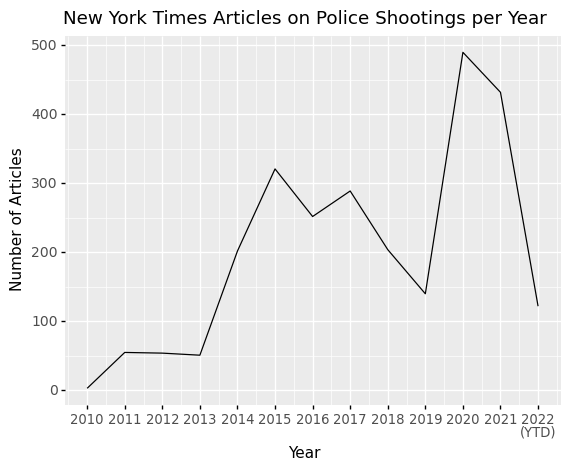

<ggplot: (8779397237742)>

In [10]:
#Plot frequency by year using ggplot
(ggplot(aes(x="year", y="text"), counts) + 
 geom_line() + 
 scale_x_continuous(breaks = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], 
                    labels = ['2010', '2011', '2012', '2013', '2014', "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022\n(YTD)"])+
 labs(title = "New York Times Articles on Police Shootings per Year",
  x = "Year", y = "Number of Articles") + theme(axis_text_x=element_text(size = 9.5), axis_text_y=element_text(size = 10))


)

In [11]:
#exploratory analysis - min doc freq
df['text_clean']  = df['text'].replace(to_replace=r"\b[0-9]+\b\s*", value="", regex=True)
bin_vect = CountVectorizer(binary=True, stop_words='english', token_pattern = r'(?u)\b\w[\w-]*\w\b')
bin_dtm = bin_vect.fit_transform(df['text_clean'])
    
term_indices = {index: term for term, index in bin_vect.vocabulary_.items()}
colterms = [term_indices[i] for i in range(bin_dtm.shape[1])]
    
doc_freq = pd.DataFrame(bin_dtm.toarray(), columns=colterms).agg('sum', axis='rows')
doc_freq

df_final = pd.DataFrame({'term':colterms, 'doc_freq':doc_freq}).reset_index(drop=True)

features_count = []
min_doc_freq = []

for i in range(0,25):
    feat_count = df_final[df_final.doc_freq > i].shape[0]
    features_count.append(feat_count)
    min_doc_freq.append(i+1)

features_count

[47696,
 31229,
 22181,
 18499,
 16003,
 14226,
 12932,
 11883,
 11027,
 10308,
 9715,
 9167,
 8721,
 8319,
 7967,
 7650,
 7342,
 7066,
 6843,
 6618,
 6404,
 6191,
 6025,
 5838,
 5676]

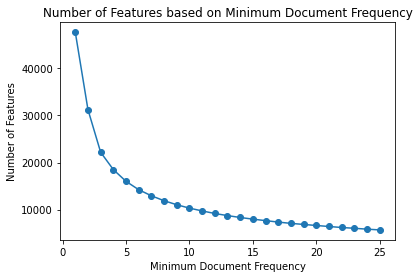

In [12]:
plt.plot(min_doc_freq, features_count, marker = 'o')
plt.xlabel('Minimum Document Frequency')
plt.ylabel('Number of Features')
plt.title('Number of Features based on Minimum Document Frequency')
plt.rcParams.update({'font.size': 14})
plt.show()

In [13]:
#exploratory analysis - check term frequencies and doc frequencies for further pre-processing steps

df['text_clean']  = df['text'].replace(to_replace=r"\b[0-9]+\b\s*", value="", regex=True)
#calculate term frequencies
bin_vect = CountVectorizer(binary=False, stop_words='english', min_df = 5, token_pattern = r'(?u)\b\w[\w-]*\w\b')
bin_dtm = bin_vect.fit_transform(df['text_clean'])

term_indices = {index: term for term, index in bin_vect.vocabulary_.items()}
colterms = [term_indices[i] for i in range(bin_dtm.shape[1])]

term_freq = pd.DataFrame(bin_dtm.toarray(), columns=colterms).agg('sum', axis='rows')
df_final = pd.DataFrame({'term':colterms, 'term_freq':term_freq}).reset_index(drop=True)

df_final.sort_values(by = 'term_freq', ascending = False).head(20)


,term,term_freq
12399,said,27307
10653,police,26665
9309,mr,26095
9786,officers,11859
9783,officer,9743
10333,people,7437
1523,black,7273
9517,new,6716
3689,death,5788
9311,ms,5654


In [14]:
#calculate doc frequencies
bin_vect = CountVectorizer(binary=True, stop_words='english', min_df = 5, token_pattern = r'(?u)\b\w[\w-]*\w\b')
bin_dtm = bin_vect.fit_transform(df['text_clean'])

term_indices = {index: term for term, index in bin_vect.vocabulary_.items()}
colterms = [term_indices[i] for i in range(bin_dtm.shape[1])]

doc_freq = pd.DataFrame(bin_dtm.toarray(), columns=colterms).agg('sum', axis='rows')
df_final = pd.DataFrame({'term':colterms, 'doc_freq':doc_freq}).reset_index(drop=True)

df_final.sort_values(by = 'doc_freq', ascending = False).head(20)


,term,doc_freq
10653,police,2591
12399,said,2398
9309,mr,2185
3689,death,1999
9517,new,1968
9786,officers,1955
10333,people,1936
9783,officer,1772
14535,times,1748
15959,york,1706


In [15]:
#update list of stop words
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS.union(["nytimes", 'www', 'https', 'com'])

In [16]:
#lemmatize tokens not in stop words list
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [''.join(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize(text) if w not in my_stop_words]

df['text_lemmatized'] = df.text.apply(lemmatize_text)
df['words'] = df['text_lemmatized'].apply(' '.join)
df['text_clean']  = df['words'].replace(to_replace=r"\b[0-9]+\b\s*", value="", regex=True)

In [17]:
df.head()

,text,date,year,time_period,text_clean,text_lemmatized,words
0,"BATON ROUGE, La. — He joined the Marines, serv...",2019-11-28,2019,Pre-George Floyd,"BATON ROUGE, La. — He joined Marines, served I...","[BATON, ROUGE,, La., —, He, joined, Marines,, ...","BATON ROUGE, La. — He joined Marines, served I..."
1,Understanding Police Killings In Police Killin...,2015-10-25,2015,Pre-George Floyd,Understanding Police Killings In Police Killin...,"[Understanding, Police, Killings, In, Police, ...",Understanding Police Killings In Police Killin...
2,Subways and Taxis How Politics and Bad Decisio...,2017-12-15,2017,Pre-George Floyd,Subways Taxis How Politics Bad Decisions Starv...,"[Subways, Taxis, How, Politics, Bad, Decisions...",Subways Taxis How Politics Bad Decisions Starv...
3,Some myths are too powerful — too necessary — ...,2020-01-24,2020,Pre-George Floyd,"Some myth powerful — necessary — fully undone,...","[Some, myth, powerful, —, necessary, —, fully,...","Some myth powerful — necessary — fully undone,..."
4,BAGHDAD -- Islamic State fighters extended the...,2016-05-13,2016,Pre-George Floyd,BAGHDAD -- Islamic State fighter extended barr...,"[BAGHDAD, --, Islamic, State, fighter, extende...",BAGHDAD -- Islamic State fighter extended barr...


In [18]:
# convert text to dtm with tfidf weighting
vect = TfidfVectorizer(stop_words=my_stop_words, min_df = 5, max_df = 0.95, token_pattern = r'(?u)\b\w[\w-]*\w\b')
dtm = vect.fit_transform(df['text_clean'])
dtm.shape

(2615, 15326)

In [19]:
# convert vocabulary to dictionary of term indices
vect.vocabulary_
term_indices = {index: term for term, index in vect.vocabulary_.items()}

In [20]:
# create a list of column names from the term indices
colterms = [term_indices[i] for i in range(dtm.shape[1])]

In [21]:
#convert to matrix
X = pd.DataFrame(dtm.toarray(), columns=colterms)
X.head()

,10th,10th-grade,11th,120th,12th,13th,14th,16th,17th-century,1800s,...,zion,zip,zoe,zolan,zone,zongo,zoning,zoo,zoom,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#recalculate term frequencies for word cloud

bin_vect = CountVectorizer(binary=False, stop_words=my_stop_words, min_df = 5, max_df = 0.95, token_pattern = r'(?u)\b\w[\w-]*\w\b')
bin_dtm = bin_vect.fit_transform(df['text_clean'])

In [23]:
term_indices = {index: term for term, index in bin_vect.vocabulary_.items()}
colterms = [term_indices[i] for i in range(bin_dtm.shape[1])]

In [24]:
term_freq = pd.DataFrame(bin_dtm.toarray(), columns=colterms).agg('sum', axis='rows')

In [25]:
df_final = pd.DataFrame({'term':colterms, 'term_freq':term_freq}).reset_index(drop=True)
 
df_final.head()

,term,term_freq
0,10th,22
1,10th-grade,5
2,11th,17
3,120th,16
4,12th,23


In [26]:
df_final.sort_values(by = 'term_freq', ascending = False).head(20)

,term,term_freq
11863,said,27307
8931,mr,26095
9381,officer,19152
9912,people,7513
1458,black,7400
9128,new,6716
3527,death,6667
2427,city,6208
8933,ms,5654
12365,shooting,5196


In [27]:
#extract top 100 terms and pivot for word cloud 
bow=df_final.sort_values(by = 'term_freq', ascending = False).head(100)
bow2 = pd.pivot(bow,  columns= 'term', values= 'term_freq')
total = bow2.sum()

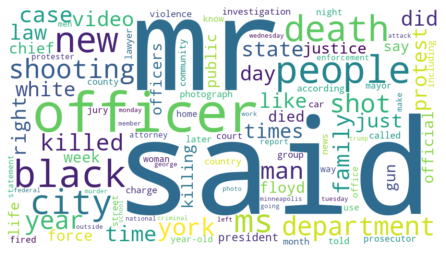

In [28]:
# generate the word cloud
wordcloud = WordCloud(background_color='white', width=900,height=500).generate_from_frequencies(total)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

time period =  Pre-BLM


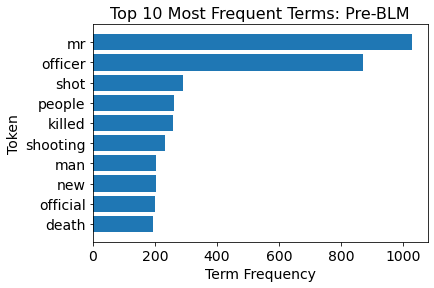

time period =  Pre-George Floyd


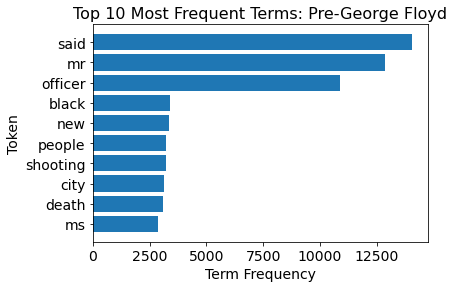

time period =  Post-George Floyd


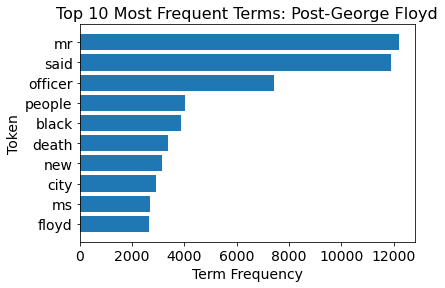

In [29]:
#re-do count vectorizer for each time period and plot most frequent terms

labels = ['Pre-BLM', "Pre-George Floyd", "Post-George Floyd"]
def plot_top_10():
    for label in labels:
        df_temp = df[df['time_period'] == label]


        bin_vect = CountVectorizer(binary=False, stop_words=my_stop_words, min_df = 5, max_df = 0.95, token_pattern = r'(?u)\b\w[\w-]*\w\b')
        bin_dtm = bin_vect.fit_transform(df_temp['text_clean'])

        term_indices = {index: term for term, index in bin_vect.vocabulary_.items()}
        colterms = [term_indices[i] for i in range(bin_dtm.shape[1])]

        doc_freq = pd.DataFrame(bin_dtm.toarray(), columns=colterms).agg('sum', axis='rows')

        df_final_temp = pd.DataFrame({'term':colterms, 'doc_freq':doc_freq}).reset_index(drop=True)
        print('time period = ', label)
        #print(df_temp.year.size)

        #plt.barh(doc_freq, colterms)
        top_df = df_final_temp.sort_values(by = 'doc_freq', ascending = False).head(10)
        fig, ax = plt.subplots()

        ax.barh(top_df.term, top_df.doc_freq,align='center')
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Term Frequency')
        ax.set_ylabel('Token')
        ax.set_title("Top 10 Most Frequent Terms: " + str(label), fontsize=16)

        plt.show()

plot_top_10()   

In [41]:
afinn = pd.read_csv('/Users/anandigupta/Downloads/afinn.csv')
vdoc_afinn = pd.merge(df_final, afinn, left_on = 'term', right_on = 'word', how='inner')
vdoc_afinn.head()

,term,term_freq,word,value
0,abandon,19,abandon,-2
1,abandoned,72,abandoned,-2
2,abducted,15,abducted,-2
3,abduction,9,abduction,-2
4,abhorrent,10,abhorrent,-3


In [42]:
#examine percent of tokens included in lexicon
len(set(vdoc_afinn.word))/len(df_final)

0.09226151637739789

In [31]:
#similarly, for each year calculate afinn score and save to list
#note, exclude 2010 because it only has 3 docs (less than the min doc freq of 5)

years = [2011, 2012, 2013, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2022, 2021, 2022]
afinn_scores = [] 

for i in years:
    df_temp = df[df['year'] == i]


    bin_vect = CountVectorizer(binary=False, stop_words=my_stop_words, min_df = 5, max_df = 0.95, token_pattern = r'(?u)\b\w[\w-]*\w\b')
    bin_dtm = bin_vect.fit_transform(df_temp['text_clean'])
    
    term_indices = {index: term for term, index in bin_vect.vocabulary_.items()}
    colterms = [term_indices[i] for i in range(bin_dtm.shape[1])]
    
    doc_freq = pd.DataFrame(bin_dtm.toarray(), columns=colterms).agg('sum', axis='rows')
    
    df_final_temp = pd.DataFrame({'term':colterms, 'doc_freq':doc_freq}).reset_index(drop=True)
    vdoc_afinn = pd.merge(df_final_temp, afinn, left_on = 'term', right_on = 'word', how='inner')
    afinn_scores.append(vdoc_afinn.value.mean())

In [32]:
print(afinn_scores)

[-0.8173076923076923, -1.0895522388059702, -0.9855072463768116, -1.0895522388059702, -0.9855072463768116, -0.5778443113772455, -0.5269709543568465, -0.5084337349397591, -0.53125, -0.3916083916083916, -0.6242236024844721, -0.7138047138047138, -0.4742857142857143, -0.7138047138047138]


In [33]:
afinn_df = pd.DataFrame()
afinn_df['years'] = years
afinn_df['afinn_score'] = afinn_scores

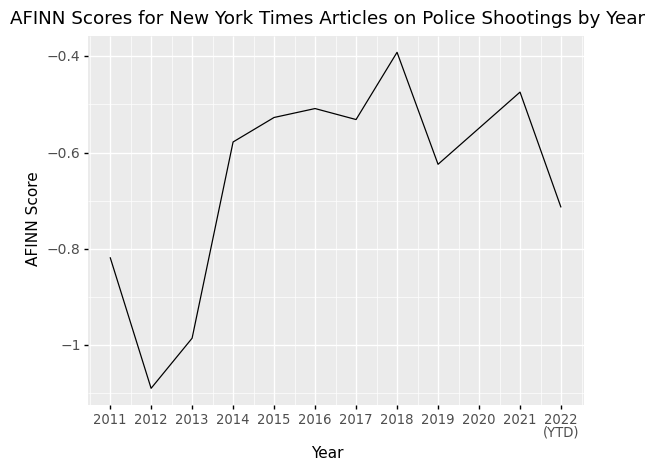

<ggplot: (8779431598071)>

In [34]:
#plot afinn scores by year

(ggplot(afinn_df, aes(x="years", y="afinn_score")) + 
 geom_line() + 
 scale_x_continuous(breaks = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022], 
                    labels = ['2011', '2012', '2013', '2014', "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022\n(YTD)"])+
 labs(title = "AFINN Scores for New York Times Articles on Police Shootings by Year",
  x = "Year", y = "AFINN Score") + theme(axis_text_x=element_text(size = 9.5), axis_text_y=element_text(size = 10))


)

In [35]:
#note - code to implement the VADER sentiment analysis in python relies on 
#https://www.kaggle.com/code/vickieshi/news-headline-sentiment-analysis

sia = SentimentIntensityAnalyzer()

#create polarity scores
df['senti_score'] = df['text'].apply(lambda text: sia.polarity_scores(text))

#extract compound scores to a new column
df['compound']  = df['senti_score'].apply(lambda score_dict: score_dict['compound'])

#create a new column for sentiment labels 
df['senti_label'] = df['compound'].apply(lambda c: 'positive' if c >=0.05 else 'neutral' if c>-0.05 else 'negative')

#counts of sentiment labels
df['senti_label'].value_counts()

negative    2333
positive     266
neutral       16
Name: senti_label, dtype: int64

In [36]:
#calculate the average compound scores per month and per year respectively
yearly_averages = df.resample('A',on='date').mean()
monthly_averages = df.resample('M',on='date').mean()

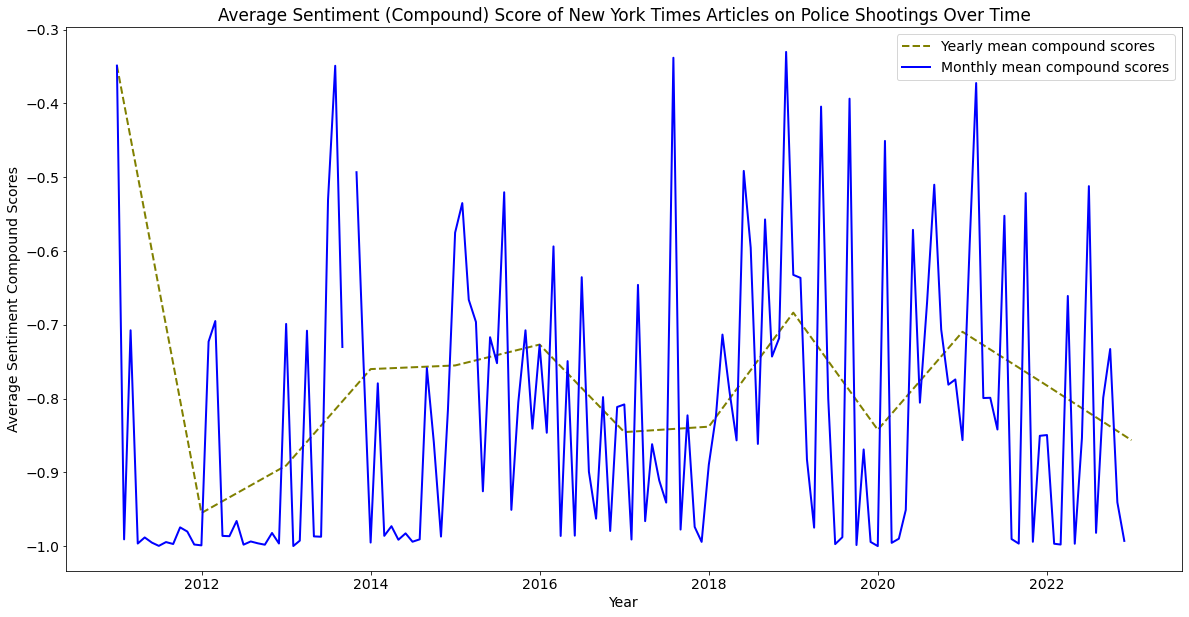

In [37]:
#visualization of vader sentiment scores
plt.figure(figsize=(20,10))
plt.plot(yearly_averages.index,yearly_averages['compound'],  color='olive', linewidth=2, linestyle='dashed', label='Yearly mean compound scores')
plt.plot(monthly_averages.index, monthly_averages['compound'], color = 'blue', linewidth=2, label='Monthly mean compound scores')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Compound Scores')
plt.title('Average Sentiment (Compound) Score of New York Times Articles on Police Shootings Over Time')
plt.rcParams.update({'font.size': 14})
plt.legend()
plt.show()

In [38]:
#group by time period for proportions chart

plot_data = df.groupby(['time_period', 'senti_label']).size().reset_index()
plot_data_t = df.groupby(['time_period']).size().reset_index()
plot_data = pd.merge(plot_data, plot_data_t, on='time_period', how='left')
plot_data = plot_data.rename(columns={'0_x': "count", '0_y': "total"})
plot_data['prop'] = plot_data['count']/plot_data['total']
plot_data

,time_period,senti_label,count,total,prop
0,Post-George Floyd,negative,890,1010,0.881188
1,Post-George Floyd,neutral,3,1010,0.002970
2,Post-George Floyd,positive,117,1010,0.115842
3,Pre-BLM,negative,130,138,0.942029
4,Pre-BLM,positive,8,138,0.057971
5,Pre-George Floyd,negative,1313,1467,0.895024
6,Pre-George Floyd,neutral,13,1467,0.008862
7,Pre-George Floyd,positive,141,1467,0.096115


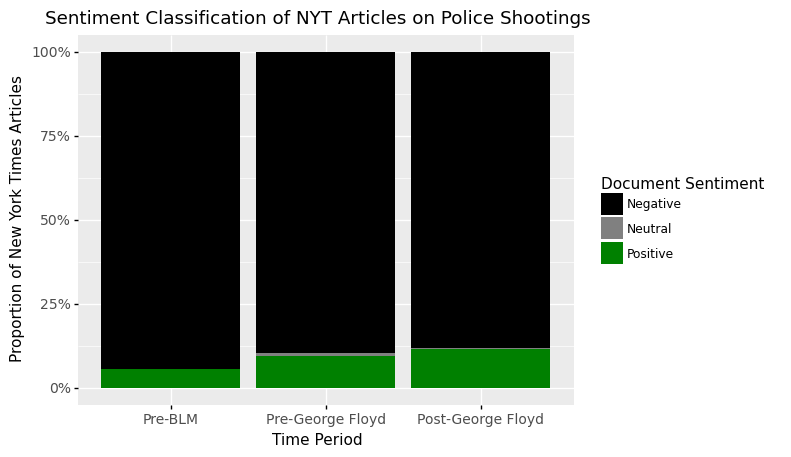

<ggplot: (8779432346829)>

In [39]:
#plot proportion of each sentiment by time period

(ggplot(plot_data, aes('factor(time_period)', 'count', fill='senti_label'))
 + geom_bar(stat = 'identity', position = 'fill') 
 + scale_y_continuous(labels=percent_format())
+ scale_fill_manual(['black', 'grey', 'green'], labels=['Negative', 'Neutral', 'Positive'], name = "Document Sentiment")
 + theme(axis_text_x=element_text(size = 10), axis_text_y=element_text(size = 10))
+
  labs(title = "Sentiment Classification of NYT Articles on Police Shootings",
  x = "Time Period", y = "Proportion of New York Times Articles") + 
scale_x_discrete(limits =["Pre-BLM", "Pre-George Floyd", "Post-George Floyd"]))